Feature selection/interpretability for instrument classification model based on the TinySOL dataset (and the data.csv file in this same folder)


## Install libraries

In [1]:
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... don

In [2]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.model_selection import train_test_split


RNG_STATE = 0

from google.colab import files


## Data loading

Reading the previously generated data.csv file from my Google Drive
---



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_file = '/content/drive/MyDrive/Colab Notebooks/Music Information Retrieval/Week 2/Assignment/TinySOL - Instrument classification with low level MusicExtractor() features/data.csv'

#uploaded = files.upload()

#Read data with pandas module

data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.972552,8.409534,1.144080,0.446386,0.060015,9.493382,19.056255,1.141775,1.308129,3.061680,...,1430.113892,6.908469,1.688109,2058337.500,1827199.000,0.307684,0.098845,0.007163,0.005299,Bass Tuba
1,0.987932,7.737574,1.062609,0.431098,0.055529,9.831431,15.997477,1.093505,1.228107,2.576996,...,794.864319,6.603456,1.446844,2004203.750,1424922.625,0.565711,0.606314,0.008125,0.007040,Bass Tuba
2,0.977264,7.017447,1.557238,0.450940,0.064779,3.441059,15.226211,0.479126,1.119596,3.132955,...,1495.037476,10.009058,2.345824,1368292.875,1768582.500,0.355884,0.159810,0.011065,0.011138,Bass Tuba
3,0.978420,8.197027,1.043337,0.407936,0.060264,12.807643,14.228601,1.277687,1.195519,2.662251,...,1696.913696,6.570394,1.548001,2211143.250,1841596.875,0.414092,0.317596,0.018260,0.014639,Bass Tuba
4,0.981588,7.884830,1.527937,0.455036,0.067737,2.158736,10.539771,0.207712,0.961212,3.402941,...,1755.925659,10.873639,2.521345,1243969.125,1803341.250,0.864981,0.496939,0.013012,0.012325,Bass Tuba


Train test splitting using sklearn

In [5]:
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)
#print('X_train')
#X_train
print(y_train_text)
y_train_text
#print('X_test')
#X_test
print('y_test_text')
y_test_text

1453        Contrabass
2020             Viola
188        French Horn
1273             Cello
1959             Viola
             ...      
763          Accordion
835          Accordion
1653        Contrabass
2607    Clarinet in Bb
2732             Flute
Name: instrument, Length: 2330, dtype: object
y_test_text


1728        Contrabass
2684    Clarinet in Bb
1151             Cello
2757             Flute
1180             Cello
             ...      
1840             Viola
776          Accordion
1519        Contrabass
1359             Cello
563          Accordion
Name: instrument, Length: 583, dtype: object

We need to encode the output labels as numbers, to have them as targets for machine learning models. 

In [6]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
'''
docs for sklearn.preprocessing.LabelEncoder

Encode target labels with value between 0 and n_classes-1.
This transformer should be used to encode target values, i.e. y, and not the input X.
'''
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text) # Fit label encoder and return encoded labels.

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

## Feature pre-processing and classification

We use a StandardScaler to do a feature normalization such as the input features have a mean zero and standard deviation 1. 
We then build a pipeline chaining the feature pre-processing and the classifier, in this case a KNN 

                precision    recall  f1-score   support

     Accordion       1.00      1.00      1.00       165
Alto Saxophone       0.90      0.90      0.90        21
     Bass Tuba       0.94      0.94      0.94        17
       Bassoon       0.88      0.88      0.88        26
         Cello       0.91      0.93      0.92        57
Clarinet in Bb       0.87      0.77      0.82        26
    Contrabass       0.98      0.92      0.95        49
         Flute       0.84      1.00      0.91        26
   French Horn       0.96      0.96      0.96        27
          Oboe       0.88      0.88      0.88        16
      Trombone       0.96      0.88      0.92        26
  Trumpet in C       0.87      0.87      0.87        15
         Viola       0.82      0.87      0.85        63
        Violin       0.91      0.88      0.90        49

      accuracy                           0.93       583
     macro avg       0.91      0.91      0.91       583
  weighted avg       0.93      0.93      0.93 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


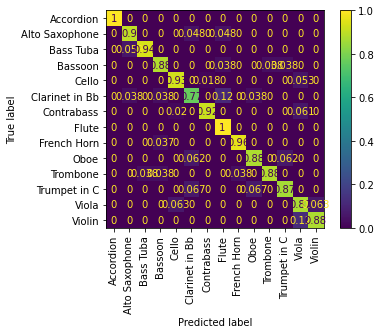

In [7]:
'''
sklearn.preprocessing.StandardScaler()

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False,
and s is the standard deviation of the training samples or one if with_std=False.
'''

# Our classifier is a "pipeline": scaling followed by KNN
# StandardScaler() is basically a feature normalizer
# make_pipeline() is a shorthand for the Pipeline constructor
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
'''
A machine learning pipeline is the end-to-end construct
that orchestrates the flow of data into, and output from, a machine learning model (or set of multiple models)

sklearn.pipeline.Pipeline docs
Pipeline of transforms with a final estimator.

Parameters:
stepslist of tuple
List of (name, transform) tuples (implementing fit/transform)
that are chained in sequential order. The last transform must be an estimator.
'''

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
'''
sklearn.metrics.classification_report

Parameters:
  y_true1d array-like, or label indicator array / sparse matrix
Ground truth (correct) target values.

  y_pred1d array-like, or label indicator array / sparse matrix
Estimated targets as returned by a classifier.

  labelsarray-like of shape (n_labels,), default=None
Optional list of label indices to include in the report.

  target_nameslist of str of shape (n_labels,), default=None
Optional display names matching the labels (same order).
'''
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

## Feature visualization

In [8]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

We visualize the data by applying a transformation using UMAP from a high dimensional space to a low dimensional space. Similarly to the PCA reduction, the output axes do not hold any specific meaning.

In [9]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

In the plot the different classes are plotted with different colors, while the train and test datasets are denoted by x or circles.
If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

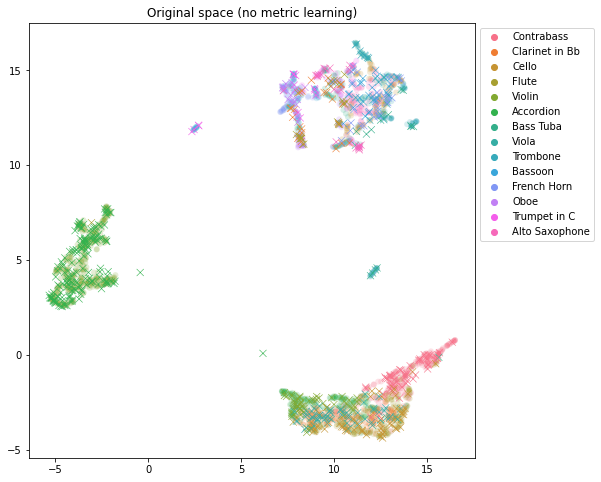

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features

We use Linear Discriminant Analysis to better separate the classes by learning a 9-dimensional projection of the features. 

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.0s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
                precision    recall  f1-score   support

     Accordion       1.00      1.00      1.00       165
Alto Saxophone       0.94      0.81      0.87        21
     Bass Tuba       0.94      1.00      0.97        17
       Bassoon       0.88      0.88      0.88        26
         Cello       0.95      0.96      0.96        57
Clarinet in Bb       0.96      0.85      0.90        26
    Contrabass       0.98      1.00      0.99        49
         Flute       0.80      0.92      0.86        26
   French Horn       0.89      0.89      0.89        27
          Oboe       0.89      1.00      0.94        16
      Trombone       0.88      0.85      0.86        26
  Trumpet in C       1.00      1.00      1.00        15
         Viola       0.96      0.87      0.92   

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


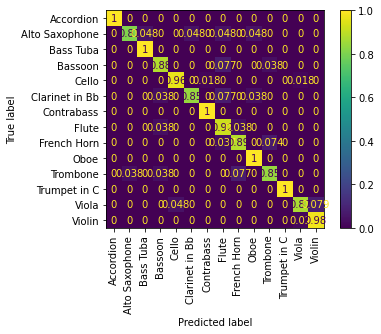

In [11]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

Let's visualize the results: 

In [12]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

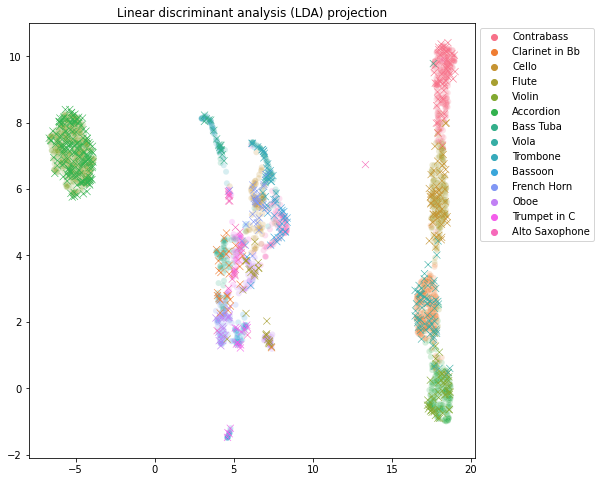

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

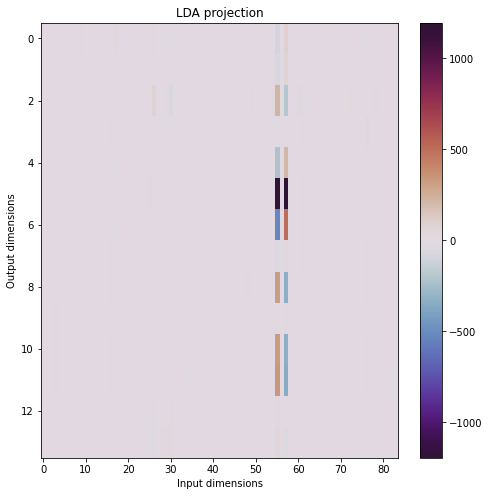

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

We can clearly see that mainly 2 features between the 50th and 60th feature are important for instrument classification. 
For 1 class only, 2 features around the 30th features are also slightly important.

Then, all other features are kind of redundant.

Which features are given more importance? 